In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
%matplotlib inline

In [4]:
#read in data (90,348 rows not inclusive of header)
df_og = pd.read_csv("data/Aviation_Data.csv")
df = df_og.copy()

print(df.info(), '\n \n')
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90348 entries, 0 to 90347
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      90348 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50132 non-null  object 
 9   Airport.Name            52704 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87507 non-null  object 
 14  Make                    88826 non-null

/var/folders/zp/y3_8cd0s1tz68ksgv9pnl2ch0000gn/T/ipykernel_77008/1295400394.py:2: DtypeWarning: Columns (6,7,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df_og = pd.read_csv("data/Aviation_Data.csv")


,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


# Preliminary Formatting Change and Filtering

In [6]:
# Replaces "." with "_" in column names for ease of copy, paste
df.columns = df.columns.str.replace('.', "_")

# Extracting year from Event Date to assess how data changes by year
df['Year'] = [str(year).split('-')[0] for year in df['Event_Date']]

# Filtering dataframe to only show entries in Aircraft_Category that are Airplane. Reducing to 27,617 rows.
df = df.loc[df['Aircraft_Category'] == 'Airplane']

# The company will utilize professionally built planes. To best understand risk associated wiht professionally
# built planes, amateur-built will be removed from the dataset. Reducing to 24,417 rows.
df = df.loc[df['Amateur_Built'] == 'No']

# Filtering dataframe to only show entries that have a Year 2000 as there were stricter air regulations enforced after 9/11
# and it makes sense to only show data around 20 years back from our problem. Reducing to 21,150 rows.
df = df.loc[df['Year'].astype(int) > 2000]

#Filtering out entries from Purpose_of_flight that arent one of 7 categories(Personal, Business, Executive/Corporate,
#Public Aircraft - Federal, Public Aircraft - State, Public Aircraft - Local or Public Aircraft)
#This is because we are looking to find an aircraft specifically for commercial and private activities. Reducing to 12,380 rows.
df = df.loc[df['Purpose_of_flight'].isin(['Personal','Business', 'Executive/corporate', 'Public Aircraft - Federal', 
                                          'Public Aircraft - State', 'Public Aircraft - Local', 'Public Aircraft'])]

# Same Makes showing up as different because of capitalization. Changing all Makes and Model to Title case
df['Make'] = [make.title() for make in df['Make']]

# For Weather Condition, unknown is represented by "Unk" and "UNK". Converting them both to "Unknown".
df = df.replace(('Unk', 'UNK'), 'Unknown')

# Replacing NaN with 0 for all injury data
df["Total_Fatal_Injuries"].fillna(0, inplace=True)
df["Total_Serious_Injuries"].fillna(0, inplace=True)
df["Total_Minor_Injuries"].fillna(0, inplace=True)
df["Total_Uninjured"].fillna(0, inplace=True)


print(df.info(), '\n \n')

/var/folders/zp/y3_8cd0s1tz68ksgv9pnl2ch0000gn/T/ipykernel_77008/1160666765.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Total_Fatal_Injuries"].fillna(0, inplace=True)
/var/folders/zp/y3_8cd0s1tz68ksgv9pnl2ch0000gn/T/ipykernel_77008/1160666765.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

<class 'pandas.core.frame.DataFrame'>
Index: 12380 entries, 49949 to 90345
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event_Id                12380 non-null  object 
 1   Investigation_Type      12380 non-null  object 
 2   Accident_Number         12380 non-null  object 
 3   Event_Date              12380 non-null  object 
 4   Location                12379 non-null  object 
 5   Country                 12380 non-null  object 
 6   Latitude                12264 non-null  object 
 7   Longitude               12259 non-null  object 
 8   Airport_Code            8930 non-null   object 
 9   Airport_Name            8975 non-null   object 
 10  Injury_Severity         12365 non-null  object 
 11  Aircraft_damage         12318 non-null  object 
 12  Aircraft_Category       12380 non-null  object 
 13  Registration_Number     12348 non-null  object 
 14  Make                    12380 non-null 

## Exploratory Data Analysis

In [8]:
#Create a Value Count for each column
for i in range(len(df.columns)):
    print(df.iloc[:, i].value_counts(), '\n', '\n', '----------------------------------------\n')

Event_Id
20030625X00951    2
20220111104514    2
20220808105682    2
20220608105217    2
20220818105763    2
                 ..
20101021X62502    1
20101026X44534    1
20101023X35000    1
20101025X33022    1
20221227106497    1
Name: count, Length: 12372, dtype: int64 
 
 ----------------------------------------

Investigation_Type
Accident    12264
Incident      116
Name: count, dtype: int64 
 
 ----------------------------------------

Accident_Number
ERA22LA103    2
ERA22LA364    2
WPR22LA201    2
WPR22FA309    2
ERA22LA379    2
             ..
ERA11LA033    1
WPR11FA021    1
CEN11FA040    1
WPR11CA024    1
WPR23LA075    1
Name: count, Length: 12373, dtype: int64 
 
 ----------------------------------------

Event_Date
2007-10-07    10
2008-08-02    10
2008-06-29    10
2022-07-15    10
2011-07-23    10
              ..
2012-12-17     1
2012-12-18     1
2012-12-20     1
2012-12-24     1
2022-12-26     1
Name: count, Length: 5445, dtype: int64 
 
 ------------------------------------

In [9]:
inv_years = df['Year']
inv_years_dist = inv_years.value_counts().sort_index()
inv_years_dist

Year
2001     23
2002     38
2003    100
2004    284
2005    400
2006    416
2007    555
2008    814
2009    790
2010    823
2011    795
2012    783
2013    673
2014    644
2015    684
2016    695
2017    665
2018    657
2019    652
2020    595
2021    640
2022    654
Name: count, dtype: int64

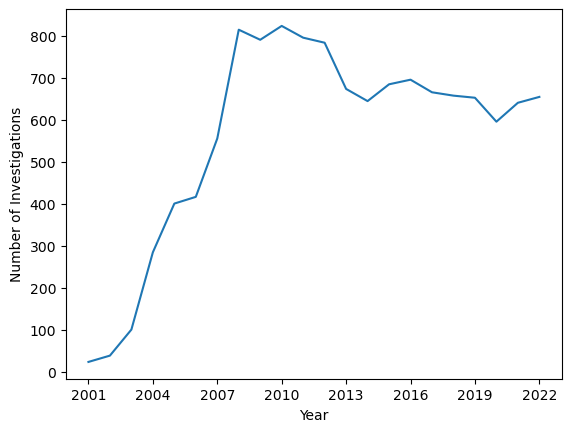

In [10]:
fig, ax = plt.subplots()

ax.plot(inv_years_dist.index, inv_years_dist.values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

ax.set_ylabel('Number of Investigations')
ax.set_xlabel("Year")
plt.show()

##  Quantifying impact to human safety and airplane damage

In [12]:
#Calculating the total number of passengers (assuming) = killed + injured + not-injured and per cent of passengers
#killed or injured. Total Passengers = 0 for 25 entries.

df['Total_Passengers'] = df['Total_Fatal_Injuries'] + df['Total_Serious_Injuries'] + df['Total_Minor_Injuries'] + df['Total_Uninjured']

df['Fatality_pct'] = df['Total_Fatal_Injuries'] / df['Total_Passengers'] * 100

df['Injured_pct'] = (df['Total_Serious_Injuries'] + df['Total_Minor_Injuries']) / df['Total_Passengers'] * 100

In [13]:
#Assuming Aircraft_damage = NaN or Unknown = No damage. Created new feature 'Airplane_Damage' to capture these
#definitions.

ad_dict = {'Destroyed' : 'Destroyed', 'Substantial' : 'Substantial', 'Minor' : 'Minor', 'Unknown' : 'No damage', np.nan : 'No damage'}
df['Airplane_Damage'] = df['Aircraft_damage'].map(ad_dict)

In [14]:
# Making Airplane_Damage quantitative
ad_dict_quant = {'Destroyed' : 4, 'Substantial' : 3, 'Minor' : 2, 'No damage' : 1}
df['Airplane_Damage_quant'] = df['Airplane_Damage'].map(ad_dict_quant)

In [15]:
df['Make'].value_counts().sort_values(ascending = False)[:20]

Make
Cessna                       4349
Piper                        2720
Beech                        1024
Mooney                        310
Maule                         196
Bellanca                      179
Cirrus Design Corp            167
Aeronca                       163
Champion                      131
Luscombe                      126
Stinson                       117
Boeing                         97
Cirrus                         86
North American                 84
Taylorcraft                    78
Aviat Aircraft Inc             68
Aviat                          61
Socata                         58
Raytheon Aircraft Company      47
Ercoupe                        45
Name: count, dtype: int64

In [16]:
# Looking at Boeing
df.loc[df['Make'] == 'Boeing'][['Make', 'Model']]

,Make,Model
54831,Boeing,A75N1(PT17)
57173,Boeing,A75N1
58553,Boeing,B75N1
58770,Boeing,A75N-1
59483,Boeing,A75N1
...,...,...
89829,Boeing,A75N1
89830,Boeing,A75N1
89859,Boeing,A75N1(PT17)
90132,Boeing,A75N1(PT17)


In [17]:
# Looking at Boeing
df.loc[df['Make'] == 'Boeing']['Model'].value_counts()

Model
A75N1(PT17)      27
B75N1            17
A75N1            14
E75               6
B75               5
A75N1 (PT17)      4
A75               4
D75N1             2
A75L300           2
E75N1             2
75                1
707-321B          1
737               1
PT 13             1
PT 17             1
A75N1 (PT-17)     1
A75L3             1
PT-13B            1
PT17              1
A75N-1            1
1942              1
A-75N1            1
N2S-3             1
PT-17             1
Name: count, dtype: int64

In [18]:
# Looking at Airbus
df.loc[df['Make'] == 'Airbus']['Model'].value_counts()

Model
A330    1
Name: count, dtype: int64

In [19]:
# Looking at Embraer
df.loc[df['Make'] == 'Embraer']['Model'].value_counts()

Model
EMB-500     3
EMB711      2
500         1
810D        1
711ST       1
EMB 720C    1
EMB-505     1
EMB-710C    1
EMB721C     1
EMB720      1
EMB820      1
EMB500      1
Name: count, dtype: int64

In [20]:
# Looking at Bombardier
df.loc[df['Make'] == 'Bombardier']['Model'].value_counts()

Model
CL-600-2B16    1
BD100 1A10     1
Name: count, dtype: int64

In [21]:
# Boeing stats
Boeing_fat_pct = df.loc[df['Make'] == 'Boeing'][['Fatality_pct', 'Injured_pct', 'Airplane_Damage_quant']]
Boeing_fat_pct.describe()

,Fatality_pct,Injured_pct,Airplane_Damage_quant
count,97.000000,97.000000,97.000000
mean,2.577320,24.742268,2.979381
std,13.250656,40.261975,0.142842
min,0.000000,0.000000,2.000000
25%,0.000000,0.000000,3.000000
50%,0.000000,0.000000,3.000000
75%,0.000000,50.000000,3.000000
max,100.000000,100.000000,3.000000


In [22]:
# Combine Make and Model into new column
df['Make_Model'] = df['Make'] + " " + df['Model']

In [23]:
df['Make_Model'].value_counts().sort_values(ascending = False)[:20]

Make_Model
Cessna 172                 371
Cessna 182                 196
Cessna 180                 193
Piper PA28                 145
Beech A36                  145
Piper PA-18-150            144
Cessna 172N                141
Cirrus Design Corp SR22    120
Cessna 152                 115
Cessna 172M                112
Piper PA-28-140            110
Cessna 172S                110
Cessna 150                 108
Cessna 140                  98
Cessna 170B                 93
Piper PA-28-180             86
Mooney M20J                 78
Cessna A185F                77
Aeronca 7AC                 73
Cessna 210                  70
Name: count, dtype: int64

In [24]:
# New df with make, mm, fat, inj, damage

df_outcomes = df[['Make', 'Make_Model', 'Fatality_pct', 'Injured_pct', 'Airplane_Damage_quant']]
df_outcomes

,Make,Make_Model,Fatality_pct,Injured_pct,Airplane_Damage_quant
49949,Learjet,Learjet LJ-60,0.0,100.0,4
49961,Beech,Beech 95-55,100.0,0.0,4
49991,Beech,Beech F90-42,100.0,0.0,4
49999,Cessna,Cessna 310R,100.0,0.0,4
50058,Dassault-Breguet,Dassault-Breguet MYSTERE FALCON 900,0.0,0.0,3
...,...,...,...,...,...
90318,Arado-Flugzeugwerke Gmbh,Arado-Flugzeugwerke Gmbh FW190 A-5,0.0,0.0,3
90320,Cessna,Cessna 305A,0.0,0.0,3
90332,Cirrus Design Corp,Cirrus Design Corp SR22,0.0,0.0,3
90336,Cessna,Cessna R172K,0.0,100.0,3


In [68]:
# New df with make, mm, fat, inj, damage

df_outcomes_com = df_com[['Make', 'Fatality_pct', 'Injured_pct', 'Airplane_Damage_quant']]
df_outcomes_com

,Make,Fatality_pct,Injured_pct,Airplane_Damage_quant
49961,Beech,100.0,0.0,4
49999,Cessna,100.0,0.0,4
50100,Cessna,0.0,0.0,3
50182,Aero Commander,100.0,0.0,4
50289,Piper,0.0,100.0,3
...,...,...,...,...
90318,Arado-Flugzeugwerke Gmbh,0.0,0.0,3
90320,Cessna,0.0,0.0,3
90332,Cirrus Design Corp,0.0,0.0,3
90336,Cessna,0.0,100.0,3


In [25]:
df_outcomes.describe()

,Fatality_pct,Injured_pct,Airplane_Damage_quant
count,12355.000000,12355.000000,12380.000000
mean,16.300390,22.163194,3.071082
std,36.133122,39.590011,0.362586
min,0.000000,0.000000,1.000000
25%,0.000000,0.000000,3.000000
50%,0.000000,0.000000,3.000000
75%,0.000000,25.000000,3.000000
max,100.000000,100.000000,4.000000


In [26]:
df_outcomes.loc[df_outcomes['Make'] == 'Boeing'].describe()

,Fatality_pct,Injured_pct,Airplane_Damage_quant
count,97.000000,97.000000,97.000000
mean,2.577320,24.742268,2.979381
std,13.250656,40.261975,0.142842
min,0.000000,0.000000,2.000000
25%,0.000000,0.000000,3.000000
50%,0.000000,0.000000,3.000000
75%,0.000000,50.000000,3.000000
max,100.000000,100.000000,3.000000


In [27]:
df_outcomes.groupby('Make_Model')[['Fatality_pct', 'Injured_pct', 'Airplane_Damage_quant']].mean()

,Fatality_pct,Injured_pct,Airplane_Damage_quant
Make_Model,,,
177Mf Llc PITTS MODEL 12,0.0,100.0,3.0
2021Fx3 Llc CCX-2000,0.0,0.0,3.0
Aaa Aircraft Llc CCX-2000,0.0,0.0,3.0
Ab Sportine Aviacija Genesis 2,0.0,0.0,3.0
Adams Dennis Allen VARIEZE,0.0,100.0,3.0
...,...,...,...
Zlin Aviation Savage Cub-S,0.0,0.0,3.0
Zlin Savage,0.0,0.0,3.0
Zlin Z143,0.0,0.0,3.0


In [28]:
df_outcomes.groupby('Make_Model')['Airplane_Damage_quant'].mean().sort_values(ascending = False)

Make_Model
Grumman Aircraft Eng Corp C-1A             4.0
Quicksilver Enterprises Inc MXL II         4.0
Cessna Aircraft Co LC42-550FG              4.0
Cessna Aircraft 182P                       4.0
Cessna Aircraft 177B                       4.0
                                          ... 
Gulfstream Aerospace G V                   1.0
Airbus A330                                1.0
Piper Aircraft Corporation PIPER J3C-65    1.0
Green L/Gilner D RV-4                      1.0
Gulfstream Aerospace G-200                 1.0
Name: Airplane_Damage_quant, Length: 2664, dtype: float64

In [29]:
# Seperating flights by Commercial vs Private
df_com = df.loc[df['Purpose_of_flight'].isin(['Personal', 'Public Aircraft - Federal', 
                                          'Public Aircraft - State', 'Public Aircraft - Local', 'Public Aircraft'])]
df_pri = df.loc[df['Purpose_of_flight'].isin(['Business', 'Executive/corporate'])]

In [84]:
df_com = df_com.loc[df_com['Make'].isin(list(df_com['Make'].value_counts()[:20].index))]
df_com['Make'].value_counts()

Make
Cessna                         4146
Piper                          2635
Beech                           944
Mooney                          303
Maule                           193
Bellanca                        176
Aeronca                         163
Cirrus Design Corp              154
Champion                        130
Luscombe                        126
Stinson                         115
Boeing                           94
North American                   82
Cirrus                           82
Taylorcraft                      78
Aviat Aircraft Inc               67
Aviat                            61
Socata                           50
Ercoupe                          45
Grumman American Avn. Corp.      43
Name: count, dtype: int64

In [86]:
df_pri = df_pri.loc[df_pri['Make'].isin(list(df_pri['Make'].value_counts()[:20].index))]
df_pri['Make'].value_counts()

Make
Cessna                       203
Piper                         85
Beech                         80
Raytheon Aircraft Company     15
Cirrus Design Corp            13
Dehavilland                   10
Gulfstream Aerospace           8
Socata                         8
Aero Commander                 7
Mooney                         7
Raytheon                       5
Learjet                        5
Cirrus Design Corp.            5
Air Tractor                    4
Cirrus                         4
Gulfstream                     4
Learjet Inc                    4
Pilatus                        4
Dassault-Breguet               4
Textron Aviation Inc           3
Name: count, dtype: int64

In [74]:
df_com['Make'].value_counts().sort_values(ascending = False)[:20]

Make
Cessna                         4146
Piper                          2635
Beech                           944
Mooney                          303
Maule                           193
Bellanca                        176
Aeronca                         163
Cirrus Design Corp              154
Champion                        130
Luscombe                        126
Stinson                         115
Boeing                           94
North American                   82
Cirrus                           82
Taylorcraft                      78
Aviat Aircraft Inc               67
Aviat                            61
Socata                           50
Ercoupe                          45
Grumman American Avn. Corp.      43
Name: count, dtype: int64

In [72]:
df_com['Make'].value_counts().sort_values(ascending = False)[:20].index

Index(['Cessna', 'Piper', 'Beech', 'Mooney', 'Maule', 'Bellanca', 'Aeronca',
       'Cirrus Design Corp', 'Champion', 'Luscombe', 'Stinson', 'Boeing',
       'North American', 'Cirrus', 'Taylorcraft', 'Aviat Aircraft Inc',
       'Aviat', 'Socata', 'Ercoupe', 'Grumman American Avn. Corp.'],
      dtype='object', name='Make')

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12380 entries, 49949 to 90345
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event_Id                12380 non-null  object 
 1   Investigation_Type      12380 non-null  object 
 2   Accident_Number         12380 non-null  object 
 3   Event_Date              12380 non-null  object 
 4   Location                12379 non-null  object 
 5   Country                 12380 non-null  object 
 6   Latitude                12264 non-null  object 
 7   Longitude               12259 non-null  object 
 8   Airport_Code            8930 non-null   object 
 9   Airport_Name            8975 non-null   object 
 10  Injury_Severity         12365 non-null  object 
 11  Aircraft_damage         12318 non-null  object 
 12  Aircraft_Category       12380 non-null  object 
 13  Registration_Number     12348 non-null  object 
 14  Make                    12380 non-null 

## Write to File

In [90]:
#exporting data to file for private and commercial datasets
#df_com.to_csv("data/Output_Data_commercial.csv")
#df_pri.to_csv("data/Output_Data_private.csv")

## Appendix

### Assessment of Investigation Type over Time

In [35]:
inv_years_acc = df.loc[df['Investigation_Type'] == 'Accident']['Year']
inv_years_dist_acc = inv_years_acc.value_counts().sort_index()

df_inv_type_acc = pd.DataFrame(inv_years_dist_acc).reset_index()
df_inv_type_acc.columns = ['Year', 'Accidents']

inv_years_inc = df.loc[df['Investigation_Type'] == 'Incident']['Year']
inv_years_dist_inc = inv_years_inc.value_counts().sort_index()

df_inv_type_inc = pd.DataFrame(inv_years_dist_inc).reset_index()
df_inv_type_inc.columns = ['Year', 'Incidents']

df_inv_type_merge = pd.merge(df_inv_type_acc, df_inv_type_inc, how = 'outer', on = 'Year')
df_inv_type_merge['Incidents'] = df_inv_type_merge['Incidents'].fillna(0)

df_inv_type_merge['Accidents_pct'] = df_inv_type_merge['Accidents'] / (df_inv_type_merge['Accidents'] + df_inv_type_merge['Incidents']) * 100
df_inv_type_merge['Incidents_pct'] = df_inv_type_merge['Incidents'] / (df_inv_type_merge['Accidents'] + df_inv_type_merge['Incidents']) * 100

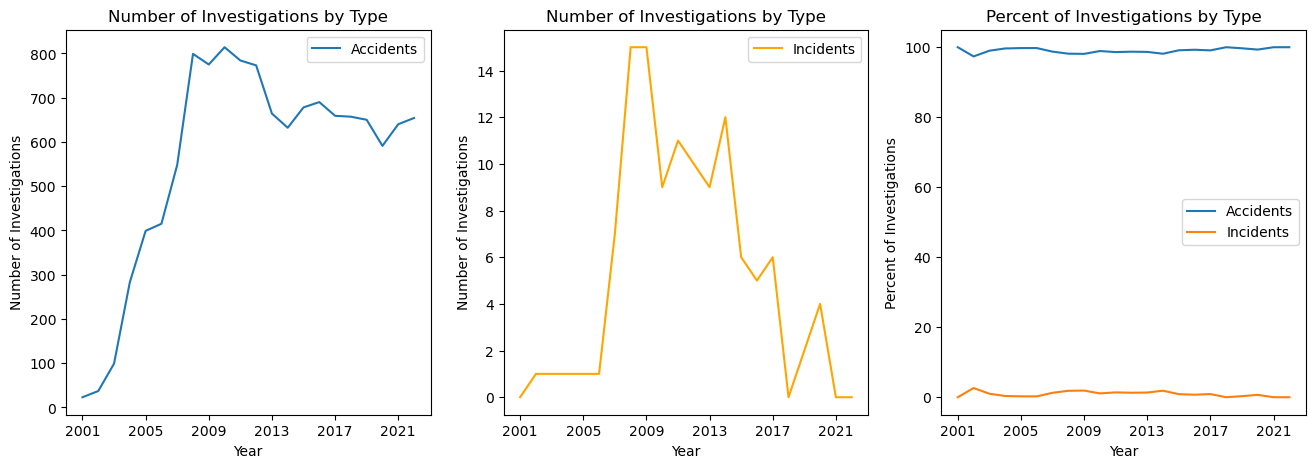

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (16, 5))

ax1.plot(df_inv_type_merge['Year'], df_inv_type_merge['Accidents'], label = 'Accidents')

ax2.plot(df_inv_type_merge['Year'], df_inv_type_merge['Incidents'], label = 'Incidents', color='orange')

ax3.plot(df_inv_type_merge['Year'], df_inv_type_merge['Accidents_pct'], label = 'Accidents')
ax3.plot(df_inv_type_merge['Year'], df_inv_type_merge['Incidents_pct'], label = 'Incidents')

ax1.legend()
ax2.legend()
ax3.legend()

ax1.xaxis.set_major_locator(ticker.MultipleLocator(4))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(4))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(4))

ax1.set_title('Number of Investigations by Type')
ax1.set_ylabel('Number of Investigations')
ax1.set_xlabel("Year")

ax2.set_title('Number of Investigations by Type')
ax2.set_ylabel('Number of Investigations')
ax2.set_xlabel("Year")

ax3.set_title('Percent of Investigations by Type')
ax3.set_ylabel('Percent of Investigations')
ax3.set_xlabel("Year")

plt.show()